# IS403.N22.HTCL
```python
Team 16
```
**SỬ DỤNG ĐỂ TÍNH TOÁN BỘ DỮ LIỆU GIÁ BẠCH KIM (19/05/2018 ĐẾN 19/05/2023)**
- Tỷ lệ tính toán Train Data: 70% Dataset
- Tỷ lệ tính toán Test Data: 20% Dataset
- Tỷ lệ tính toán Validation Data: 10% Dataset

In [1]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [2]:
#Đọc file dữ liệu và xem dữ liệu
df = pd.read_csv('../PlatiumData.csv',parse_dates=True)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,20/5/2018,886.2,886.8,889.0,885.5,NaN
1,21/5/2018,899.5,886.2,902.7,877.8,NaN
2,22/5/2018,908.3,899.5,912.0,896.3,NaN
3,23/5/2018,904.6,908.3,910.4,898.5,NaN
4,24/5/2018,910.4,904.6,914.7,903.5,NaN
...,...,...,...,...,...,...
1553,15/5/2023,1082.8,1057.6,1079.1,1057.5,NaN
1554,16/5/2023,1075.0,1070.5,1078.7,1061.8,NaN
1555,17/5/2023,1090.7,1067.7,1086.1,1067.4,NaN
1556,18/5/2023,1066.3,1079.2,1080.8,1055.0,NaN


In [3]:
#Xem các dữ liệu cơ bản của cảc thuộc tính
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,1558.000000,1558.000000,1558.000000,1558.000000
mean,944.065918,943.859884,955.499743,932.064955
std,116.994315,116.800419,119.007199,115.160228
min,595.200000,596.050000,615.400000,562.000000
25%,852.987500,852.887500,862.150000,844.275000
50%,930.875000,931.225000,941.900000,920.700000
75%,1018.200000,1017.575000,1029.475000,1003.175000
max,1318.750000,1292.800000,1351.200000,1283.150000


In [4]:
#Kiểm tra dữ liệu rỗng
df.isnull().sum()

Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL          978
dtype: int64

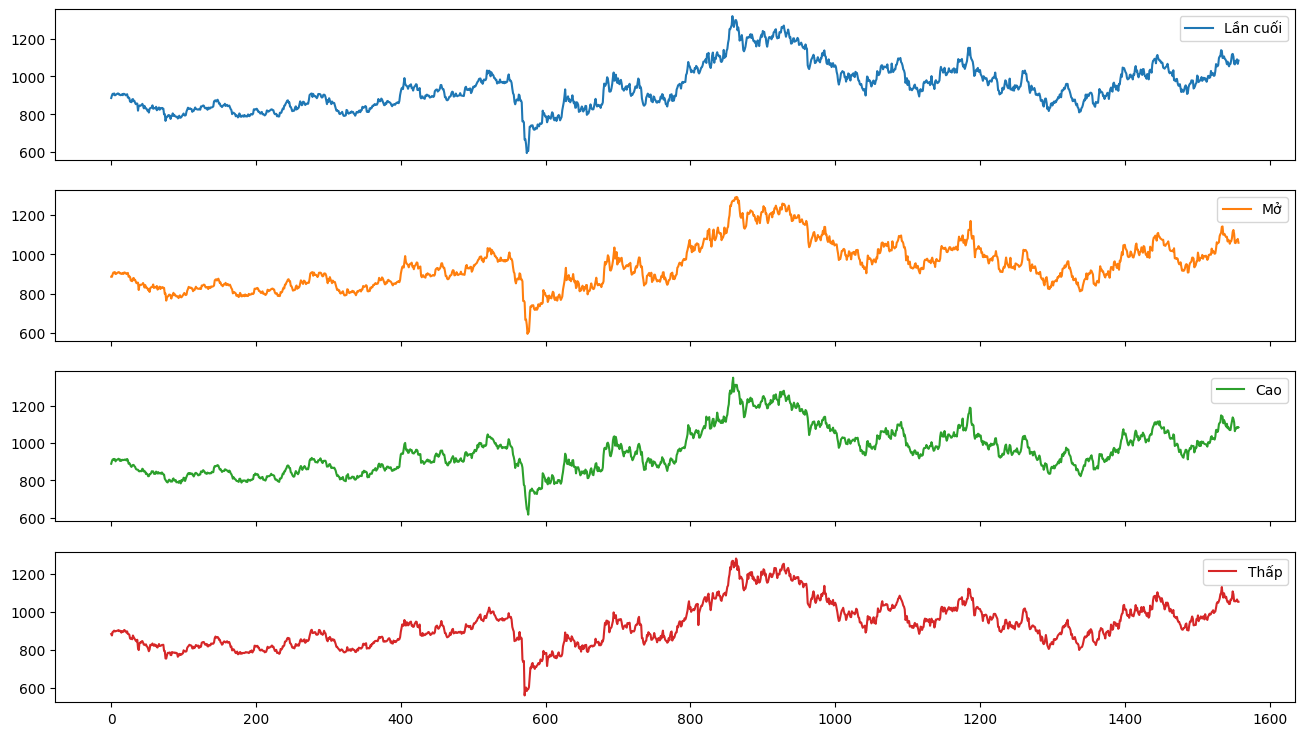

In [5]:
#Xem độ biến thiên của từng thuộc tính.
df.plot(legend=True,subplots=True, figsize = (16, 9))
plt.show()

In [6]:
#Chuyển dataset về cột Close để tiến hành tạo model
df = df[['Lần cuối']]
df

,Lần cuối
0,886.2
1,899.5
2,908.3
3,904.6
4,910.4
...,...
1553,1082.8
1554,1075.0
1555,1090.7
1556,1066.3


In [7]:
#Chia dữ liệu theo các tỷ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data_df = df[:train_size]
test_data_df = df[train_size:train_size+test_size]
val_data_df = df[train_size+test_size:]

In [8]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
#Chia data đã Scaler
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [10]:
#Tạo hàm create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)


In [11]:
#Chia thành các tập X,y
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
print(y_train)

[0.34455117 0.34800636 0.34994126 ... 0.66712736 0.69145187 0.68398867]


In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
# X_train = X_train.reshape(X_train.shape[0],1, X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] , 1)
# X_val = X_val.reshape(X_val.shape[0],1 ,X_val.shape[1] , 1)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers

class DilatedGRUCell(layers.Layer):
    def __init__(self, units, dilation_rate=1, **kwargs):
        super(DilatedGRUCell, self).__init__(**kwargs)
        self.units = units
        self.dilation_rate = dilation_rate
        self.state_size = units
        self.gru_cell = layers.GRUCell(units)
        
    def call(self, inputs, states):
        # Apply dilation to the input sequence
        inputs = inputs[:, ::self.dilation_rate]
        
        # Pass the dilated input sequence to the GRU cell
        outputs, new_states = self.gru_cell(inputs, states)
        
        return outputs, new_states

# Define the number of units in each layer
num_units = 16

# Define the input shape
input_shape = (None, 1)

# Create the input layer
inputs = layers.Input(input_shape)

# Create the first dilated RNN layer with a dilation rate of 1
x = layers.RNN(
    DilatedGRUCell(num_units, dilation_rate=1),
    return_sequences=False,
)(inputs)

# Create the second dilated RNN layer with a dilation rate of 2
x = layers.RNN(
    DilatedGRUCell(num_units, dilation_rate=2),
    return_sequences=False,  # Set return_sequences to False for the last layer
)(x[:, :, tf.newaxis])  # Add an extra dimension to the input

# Create the output layer
outputs = layers.Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

#Final layers
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

#fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=40
)

Epoch 1/40
33/33 [==============================] - 4s 31ms/step - loss: 0.1251 - mse: 0.1251 - mae: 0.2865 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0795
Epoch 2/40
33/33 [==============================] - 1s 19ms/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1411 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0762
Epoch 3/40
33/33 [==============================] - 1s 19ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1233 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0620
Epoch 4/40
33/33 [==============================] - 1s 17ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0964 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0447
Epoch 5/40
33/33 [==============================] - 1s 17ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0439 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0449
Epoch 6/40
33/33 [==============================] - 1s 18ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0317 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0426
Epoch 7/40
33/33 [====

In [14]:
# Dự đoán

# Dự đoán train
y_pred_train=model.predict(X_train)
y_train=scaler.inverse_transform(y_train.reshape(-1,1))
y_pred_train=scaler.inverse_transform(y_pred_train.reshape(-1,1))
#Dự đoán Test
y_pred_test=model.predict(X_test)
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test=scaler.inverse_transform(y_pred_test.reshape(-1,1))
#Dự đoán Validation
y_pred_val=model.predict(X_val)
y_val=scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_val=scaler.inverse_transform(y_pred_val.reshape(-1,1))

4/4 [==============================] - 0s 3ms/step


In [15]:
# Print the length
print(y_pred_test.shape[0])
print(y_test.shape[0])
print(y_pred_train.shape[0])
print(y_train.shape[0])

270
270
1049
1049


In [16]:
#Hàm visualize
def visualize(label ,pred, model_name):
  plt.figure(figsize=(12,8))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [17]:
#8. Đánh giá 
def deviation(test, pred):
  rmse= np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape= mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

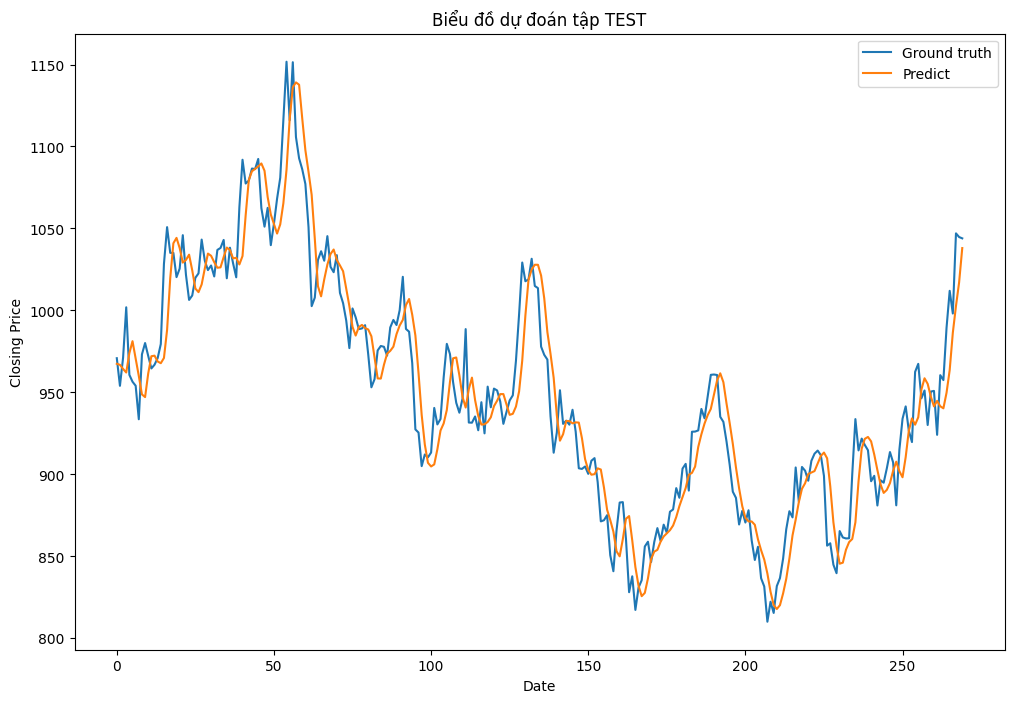

Đánh Giá tập TEST
RMSE: 22.58
MAPE: 1.86%
MAE: 17.78


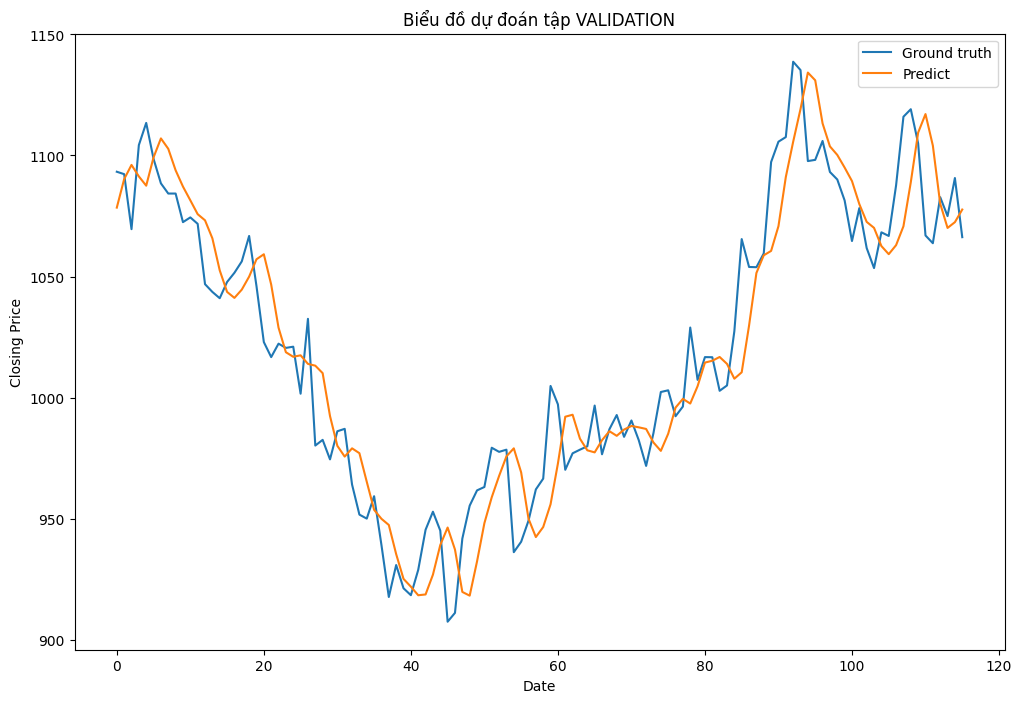

Đánh Giá tập VALIDATION
RMSE: 20.74
MAPE: 1.62%
MAE: 16.50


In [18]:
# visualize(y_train,y_pred_train,'Biểu đồ dự đoán tập TRAIN')
visualize(y_test,y_pred_test,'Biểu đồ dự đoán tập TEST')
print('Đánh Giá tập TEST')
deviation(y_test, y_pred_test)
visualize(y_val,y_pred_val,'Biểu đồ dự đoán tập VALIDATION')
print('Đánh Giá tập VALIDATION')
deviation(y_val, y_pred_val)

In [19]:
#Dự đoán 30 ngày tiếp theo
pred_next = np.array([])
  
y_val_to_next=scaler.fit_transform(np.array(y_val[-time_step:].reshape(1,-1).reshape(1,time_step)).reshape(-1,1))
  
for i in range(30):
    print(y_val_to_next)
    y_pred_next = model.predict(y_val_to_next.reshape(1,-1))
    y_val_to_next = np.append(y_val_to_next,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])
    
next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)))


[[0.        ]
 [0.02734108]
 [0.25017088]
 [0.10252905]
 [0.16678059]
 [0.16643882]
 [0.07177033]
 [0.08680793]
 [0.23991798]
 [0.49965824]
 [0.42105263]
 [0.4203691 ]
 [0.45933014]
 [0.71701982]
 [0.77443609]
 [0.7874231 ]
 [1.        ]
 [0.97641832]
 [0.71975393]
 [0.72317157]
 [0.77648667]
 [0.68899522]
 [0.66780588]
 [0.60868079]
 [0.49419002]
 [0.58714969]
 [0.47436774]
 [0.41797676]
 [0.51879699]
 [0.50854409]
 [0.65140123]
 [0.84483937]
 [0.86602871]
 [0.7696514 ]
 [0.50991114]
 [0.48803828]
 [0.61790841]
 [0.5645933 ]
 [0.67190704]
 [0.50512645]]
1/1 [==============================] - 0s 27ms/step


[0.02734108 0.25017088 0.10252905 0.16678059 0.16643882 0.07177033
 0.08680793 0.23991798 0.49965824 0.42105263 0.4203691  0.45933014
 0.71701982 0.77443609 0.7874231  1.         0.97641832 0.71975393
 0.72317157 0.77648667 0.68899522 0.66780588 0.60868079 0.49419002
 0.58714969 0.47436774 0.41797676 0.51879699 0.50854409 0.65140123
 0.84483937 0.86602871 0.7696514  0.50991114 0.48803828 0.61790841
 0.5645933  0.67190704 0.50512645 0.59796321]
1/1 [==============================] - 0s 30ms/step
[0.25017088 0.10252905 0.16678059 0.16643882 0.07177033 0.08680793
 0.23991798 0.49965824 0.42105263 0.4203691  0.45933014 0.71701982
 0.77443609 0.7874231  1.         0.97641832 0.71975393 0.72317157
 0.77648667 0.68899522 0.66780588 0.60868079 0.49419002 0.58714969
 0.47436774 0.41797676 0.51879699 0.50854409 0.65140123 0.84483937
 0.86602871 0.7696514  0.50991114 0.48803828 0.61790841 0.5645933
 0.67190704 0.50512645 0.59796321 0.57282865]
1/1 [==============================] - 0s 27ms/step
[

In [20]:
next30days_predict_inverse

,0
0,1079.882018
1,1076.204832
2,1076.634517
3,1076.424562
4,1076.331963
5,1076.240898
6,1076.149729
7,1076.056528
8,1075.962856
9,1075.870291


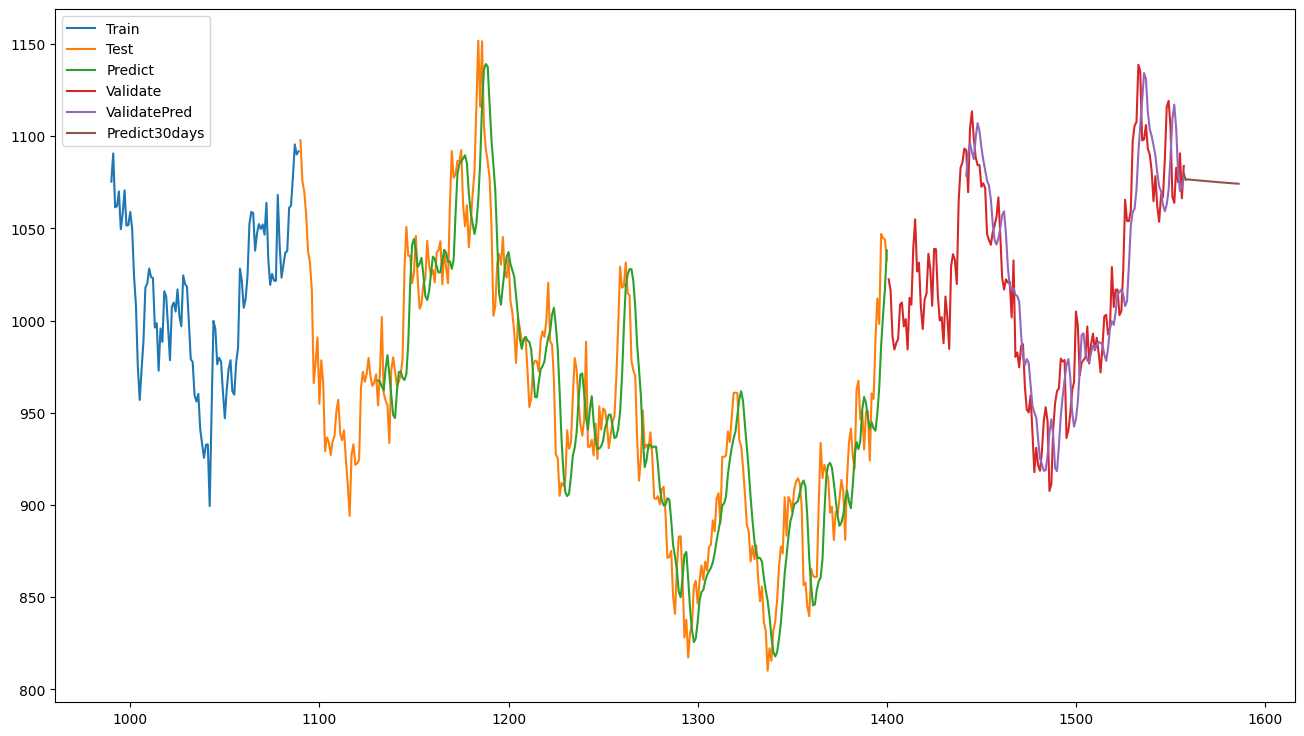

In [21]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=train_size-100, stop=train_size, step=1)
plt.plot(train_data_index,train_data_df[train_size-100:])

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, test_data_df)

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_test)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, val_data_df)

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,next30days_predict_inverse)

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [22]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 rnn (RNN)                   (None, 16)                912       
                                                                 
 tf.__operators__.getitem (S  (None, 16, 1)            0         
 licingOpLambda)                                                 
                                                                 
 rnn_1 (RNN)                 (None, 16)                912       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,841
Trainable params: 1,841
Non-trainable params: 0
___________________________________________________________